# Mass Balance Components

Here we explore components from EMY/KMR model results. 

In [47]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 

# Set global matplotlib style parameters
plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})


__Load Katie's Net Balance Results__: 

In [48]:
nc_fp = "../../input_data/mass_balance/Kaskawulsh_NetBalance.nc"

with xr.open_dataset(nc_fp) as MB_new: 
    DOY_mean = MB_new["Temp-GWA"].groupby("time.dayofyear").mean()
    DOY_std  = MB_new["Temp-GWA"].groupby("time.dayofyear").std()

In [54]:
MB_new.A.mean()*910

<xarray.DataArray 'A' ()>
array(1209.65013266)

In [53]:
MB_new['A-GWA'].groupby("time.year").sum().std()

<xarray.DataArray 'A-GWA' ()>
array(0.11504562, dtype=float32)

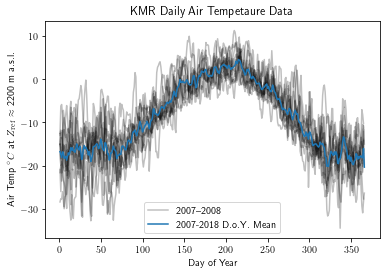

In [29]:
fig, ax = plt.subplots()

for year in np.arange(2007, 2019):
    yearly = MB_new.isel(time=MB_new.time.dt.year==year)
    
    if year == 2018: 
        ax.plot(yearly.time.dt.dayofyear, yearly["Temp-GWA"], 
                color='k', alpha=0.25, label='2007--2008')
    else: 
        ax.plot(yearly.time.dt.dayofyear, yearly["Temp-GWA"], color='k', alpha=0.25)
        
ax.plot(DOY_mean.dayofyear, DOY_mean, color='tab:blue', 
         label='2007-2018 D.o.Y. Mean')

ax.legend(loc=8)

ax.set_title('KMR Daily Air Tempetaure Data')
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'Air Temp $^\circ C$ at $Z_{\rm ref} \approx $ 2200 m a.s.l.')

fig.savefig('./figs/KMR_daily_air_temp.png', dpi=300)

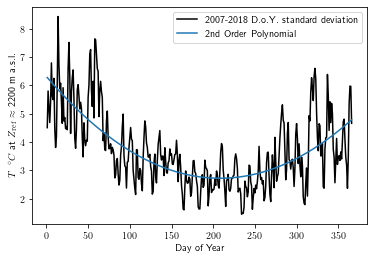

In [30]:
fig, ax = plt.subplots()

ax.plot(DOY_mean.dayofyear, DOY_std, color='k', 
         label='2007-2018 D.o.Y. standard deviation')

p = np.polyfit(DOY_mean.dayofyear, DOY_std, 2)

ax.plot(DOY_mean.dayofyear, 
        np.polyval(p, DOY_mean.dayofyear),
        label='2nd Order Polynomial')
    

ax.legend()
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'$T \;\; ^\circ C$ at $Z_{\rm ref} \approx $ 2200 m a.s.l.')

fig.savefig('./figs/KMR_daily_std_of_air_temp.png', dpi=300)

In [36]:
p = np.polyfit(DOY_mean.dayofyear, DOY_std, 2)
fancy_std = np.polyval(p, DOY_mean.dayofyear)

## Parameter Estimation 

Let us now use non-linear least squares to back out the unknown air temperature model parameters from the KMR data. Our forward model is of the form: 
$$
\begin{equation}
    T(d,z) = \alpha \cos\left( \frac{2 \pi \left(d - \hat{T} \right) }{365} \right) + T_{\rm ma} + (z - z_{\rm ref}) \frac{d T}{dz} ,
\end{equation} 
$$

where:
- $\color{blue}{ \alpha}$ is the annual air temperature amplitude (K), 
- $\color{blue}{ T_{\rm ma}}$ is the mean annual air temperature at reference elevation $z_{\rm ref}$ (K) ,
- $\color{green}{ \frac{d T}{dz}}$ is the atmospheric lapse rate (K m$^{-1}$).
- $\color{blue}{ \hat{T}}$ is the DOY of air temperature peak (d)

In [31]:
from scipy import optimize

class AirTemp:
    
    def __init__(self, T_obs): 
        
        if T_obs.size in [365, 366]: 
            self.T_obs = T_obs
            self.doy   = np.arange(1,T_obs.size+1)
        else: 
            raise ValueError('T_obs must be of size 365 or 366')
        
    def forward(self, p): 
        T = p[0] * np.cos(2 * np.pi * (self.doy - p[1]) / self.doy.size) + p[2] 
        return T

    def __cost(self, p): 
        return self.forward(p) - self.T_obs
    
    def fit(self, p0, loss='soft_l1'): 
        res_lsq = optimize.least_squares(self.__cost, p0, loss=loss)
        return res_lsq

In [32]:
Temp_model = AirTemp(DOY_mean)
res_lstq   = Temp_model.fit(p0=[10,193,-8])
predicted  = Temp_model.forward(res_lstq.x)

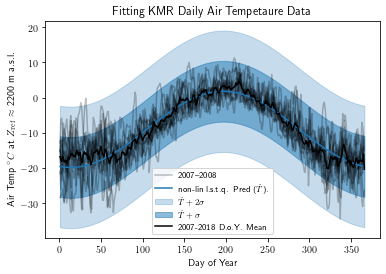

In [34]:
KMR_std = float(MB_new["Temp-GWA"].std())

fig, ax = plt.subplots()

for year in np.arange(2007, 2019):
    yearly = MB_new.isel(time=MB_new.time.dt.year==year)
    
    if year == 2018: 
        ax.plot(yearly.time.dt.dayofyear, yearly["Temp-GWA"], 
                color='k', alpha=0.25, label='2007--2008')
    else: 
        ax.plot(yearly.time.dt.dayofyear, yearly["Temp-GWA"], color='k', alpha=0.25)
            
ax.plot(DOY_mean.dayofyear, predicted, 
        label=r'non-lin l.s.t.q. Pred ($\hat T$).')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-2*KMR_std, 
                predicted+2*KMR_std, 
                alpha=0.25, color='tab:blue', 
                label='$\hat T + 2 \sigma$')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-KMR_std, 
                predicted+KMR_std,
                alpha=0.5, color='tab:blue',
                label='$\hat T + \sigma$')
    
ax.plot(DOY_mean.dayofyear, DOY_mean, color='k', 
         label='2007-2018 D.o.Y. Mean')

ax.legend(fontsize='small')

ax.set_title('Fitting KMR Daily Air Tempetaure Data')
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'Air Temp $^\circ C$ at $Z_{\rm ref} \approx $ 2200 m a.s.l.')

fig.savefig('./figs/FIT_KMR_daily_air_temp.png', dpi=300)

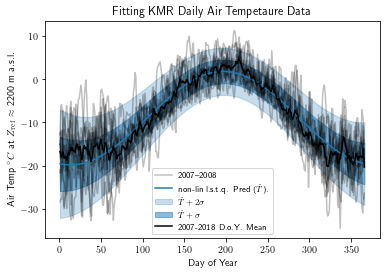

In [37]:
fig, ax = plt.subplots()

for year in np.arange(2007, 2019):
    yearly = MB_new.isel(time=MB_new.time.dt.year==year)
    
    if year == 2018: 
        ax.plot(yearly.time.dt.dayofyear, yearly["Temp-GWA"], 
                color='k', alpha=0.25, label='2007--2008')
    else: 
        ax.plot(yearly.time.dt.dayofyear, yearly["Temp-GWA"], color='k', alpha=0.25)
            
ax.plot(DOY_mean.dayofyear, predicted, 
        label=r'non-lin l.s.t.q. Pred ($\hat T$).')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-2*fancy_std, predicted+2*fancy_std, 
                alpha=0.25, color='tab:blue', 
                label='$\hat T + 2 \sigma$')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-fancy_std, predicted+fancy_std,
                alpha=0.5, color='tab:blue',
                label='$\hat T + \sigma$')
    
ax.plot(DOY_mean.dayofyear, DOY_mean, color='k', 
         label='2007-2018 D.o.Y. Mean')

ax.legend(fontsize='small')

ax.set_title('Fitting KMR Daily Air Tempetaure Data')
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'Air Temp $^\circ C$ at $Z_{\rm ref} \approx $ 2200 m a.s.l.')

fig.savefig('./figs/FIT_wfancystd_KMR_daily_air_temp.png', dpi=300)

In [39]:
print(res_lstq.x)

[ 10.82191024 196.65566994  -9.01262177]


In [55]:
p

array([ 8.29376332e-05, -3.45256005e-02,  6.31076200e+00])